# **NOTEBOOK: Implementing SHAP into different blackbox models**

STEP 1: Find data and clean it

In [47]:
import pandas as pd


from sklearn.model_selection import train_test_split

# Load the data
data = pd.read_csv('/Users/lauracohen/Desktop/Centrale 1A/Parcours recherche/mimic-iv-clinical-database-demo-2.2/hosp/admissions.csv')
data2 = pd.read_csv('/Users/lauracohen/Desktop/Centrale 1A/Parcours recherche/mimic-iv-clinical-database-demo-2.2/hosp/emar.csv')

data.head()

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,language,marital_status,race,edregtime,edouttime,hospital_expire_flag
0,10004235,24181354,2196-02-24 14:38:00,2196-03-04 14:02:00,NaN,URGENT,P03YMR,TRANSFER FROM HOSPITAL,SKILLED NURSING FACILITY,Medicaid,ENGLISH,SINGLE,BLACK/CAPE VERDEAN,2196-02-24 12:15:00,2196-02-24 17:07:00,0
1,10009628,25926192,2153-09-17 17:08:00,2153-09-25 13:20:00,NaN,URGENT,P41R5N,TRANSFER FROM HOSPITAL,HOME HEALTH CARE,Medicaid,?,MARRIED,HISPANIC/LATINO - PUERTO RICAN,NaN,NaN,0
2,10018081,23983182,2134-08-18 02:02:00,2134-08-23 19:35:00,NaN,URGENT,P233F6,TRANSFER FROM HOSPITAL,SKILLED NURSING FACILITY,Medicare,ENGLISH,MARRIED,WHITE,2134-08-17 16:24:00,2134-08-18 03:15:00,0
3,10006053,22942076,2111-11-13 23:39:00,2111-11-15 17:20:00,2111-11-15 17:20:00,URGENT,P38TI6,TRANSFER FROM HOSPITAL,DIED,Medicaid,ENGLISH,NaN,UNKNOWN,NaN,NaN,1
4,10031404,21606243,2113-08-04 18:46:00,2113-08-06 20:57:00,NaN,URGENT,P07HDB,TRANSFER FROM HOSPITAL,HOME,Other,ENGLISH,WIDOWED,WHITE,NaN,NaN,0


In [48]:
#add binary death columns

data['death'] = data['deathtime'].notnull().astype(int)

data=data.drop(['discharge_location','edregtime', 'edouttime'], axis=1)


In [50]:
data['admitted_hour'] = pd.to_datetime(data['admittime']).dt.hour

y= data.death
X=data.drop(["hospital_expire_flag","death"], axis=1)


In [51]:
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)



for i in X_train_full.columns:
    if  X_train_full[i].dtype=="object": 
        print(i, X_train_full[i].nunique())

admittime 220
dischtime 220
deathtime 11
admission_type 9
admit_provider_id 145
admission_location 10
insurance 3
language 2
marital_status 4
race 14


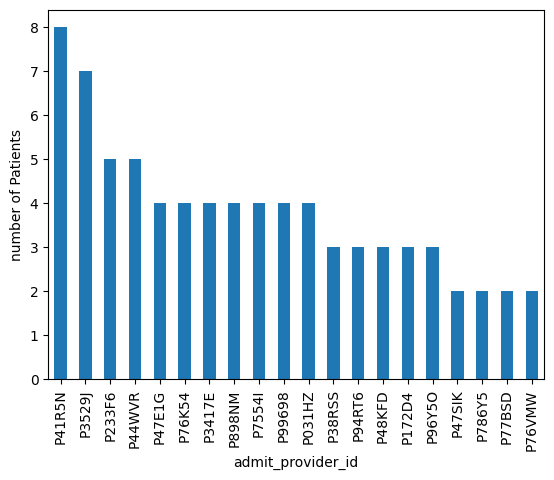

In [52]:
import matplotlib.pyplot as plt
patient_counts = data.groupby("admit_provider_id")["subject_id"].nunique()
proportions = 100*patient_counts / patient_counts.sum()
proportions_sorted = proportions.sort_values(ascending=False)
patient_counts_sorted=patient_counts.sort_values(ascending=False)

patient_counts_sorted.head(20).plot(kind="bar")
plt.ylabel("number of Patients")
plt.show()

#we see that providers only tackle a few patients, the provider feature therefore must be ignored

In [53]:
X_train_full=X_train_full.drop(["admit_provider_id"], axis=1)
X_train_full.head()

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,insurance,language,marital_status,race,admitted_hour
106,10026406,25260176,2129-01-03 15:55:00,2129-01-05 14:10:00,NaN,EW EMER.,EMERGENCY ROOM,Other,ENGLISH,DIVORCED,WHITE,15
157,10001217,27703517,2157-12-18 16:58:00,2157-12-24 14:55:00,NaN,DIRECT EMER.,PHYSICIAN REFERRAL,Other,?,MARRIED,WHITE,16
81,10021487,26321862,2117-01-28 00:19:00,2117-02-05 15:40:00,NaN,EW EMER.,EMERGENCY ROOM,Other,ENGLISH,MARRIED,WHITE,0
135,10038999,29026789,2132-05-17 23:32:00,2132-05-23 13:01:00,NaN,EW EMER.,TRANSFER FROM HOSPITAL,Medicare,ENGLISH,SINGLE,WHITE,23
156,10004235,22187210,2196-06-20 21:11:00,2196-06-22 13:30:00,NaN,DIRECT EMER.,PHYSICIAN REFERRAL,Medicaid,ENGLISH,SINGLE,BLACK/CAPE VERDEAN,21


In [58]:
features=["subject_id", "admission_type", "insurance", "language", "marital_status", "race", "admitted_hour"]
X_valid=X_valid_full[features].copy()
X_train=X_train_full[features].copy()

In [91]:
X_train.loc[data["race"].str.contains("black", case=False, na=False), "race"] = "BLACK"
X_valid.loc[data["race"].str.contains("black", case=False, na=False), "race"] = "BLACK"
X_train.loc[data["race"].str.contains("hispanic", case=False, na=False), "race"] = "HISPANIC/LATINO"
X_valid.loc[data["race"].str.contains("hispanic", case=False, na=False), "race"] = "HISPANIC/LATINO"
X_train.loc[data["race"].str.contains("WHITE", case=False, na=False), "race"] = "WHITE"
X_valid.loc[data["race"].str.contains("WHITE", case=False, na=False), "race"] = "WHITE"
X_train.loc[data["race"].str.contains("UNABLE TO OBTAIN", case=False, na=False), "race"] = "UNKNOWN"
X_valid.loc[data["race"].str.contains("UNABLE TO OBTAIN", case=False, na=False), "race"] = "UNKNOWN"
X_train.loc[data["race"].str.contains("PORTUGUESE", case=False, na=False), "race"] = "WHITE"
X_valid.loc[data["race"].str.contains("PORTUGUESE", case=False, na=False), "race"] = "WHITE"
X_train.loc[data["race"].str.contains("PATIENT DECLINED TO ANSWER", case=False, na=False), "race"] = "UNKNOWN"
X_train.loc[data["race"].str.contains("OTHER", case=False, na=False), "race"] = "UNKNOWN"
X_train.loc[data["language"].str.contains(r"\?", case=False, na=False), "language"] = "UNKNOWN"
X_train.loc[data["language"].str.contains(r"\?", case=False, na=False), "language"] = "UNKNOWN"


display(X_valid.head())
display(X_train.head())




,subject_id,admission_type,insurance,language,marital_status,race,admitted_hour
118,10012853,EW EMER.,Medicare,ENGLISH,WIDOWED,BLACK,21
182,10014354,EU OBSERVATION,Other,ENGLISH,SINGLE,WHITE,0
214,10014354,OBSERVATION ADMIT,Other,ENGLISH,SINGLE,WHITE,20
153,10002428,EW EMER.,Medicare,ENGLISH,WIDOWED,WHITE,20
209,10015860,OBSERVATION ADMIT,Other,ENGLISH,SINGLE,WHITE,16


,subject_id,admission_type,insurance,language,marital_status,race,admitted_hour
106,10026406,EW EMER.,Other,ENGLISH,DIVORCED,WHITE,15
157,10001217,DIRECT EMER.,Other,UNKNOWN,MARRIED,WHITE,16
81,10021487,EW EMER.,Other,ENGLISH,MARRIED,WHITE,0
135,10038999,EW EMER.,Medicare,ENGLISH,SINGLE,WHITE,23
156,10004235,DIRECT EMER.,Medicaid,ENGLISH,SINGLE,BLACK,21


In [125]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score


categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])
preprocessor = ColumnTransformer(
    transformers=[

        ('cat', categorical_transformer, [cname for  cname in X_train.columns if X_train[cname].dtype == "object"])
    ])
               

def test(n):
    model = RandomForestClassifier(n_estimators=n, random_state=44)

    my_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    # Fit
    my_pipeline.fit(X_train, y_train)

    # Predict probabilities for AUC
    preds = my_pipeline.predict_proba(X_valid)[:,1]

    # Evaluate
    return roc_auc_score(y_valid, preds)
    

In [126]:
for i in range(50,600,50):
    print(i, test(i))

50 0.5
100 0.6127450980392156
150 0.6764705882352942
200 0.678921568627451
250 0.6740196078431373
300 0.7524509803921569
350 0.747549019607843
400 0.7524509803921569
450 0.7475490196078431
500 0.7475490196078431
550 0.7475490196078431


we pick 300



STEP 2: implementing SHAP:



In [129]:
import eli5
from eli5.sklearn import PermutationImportance

my_pipeline.fit(X_train, y_train)

X_valid_transformed = my_pipeline.named_steps['preprocessor'].transform(X_valid)
if hasattr(X_valid_transformed, "toarray"):
    X_valid_transformed = X_valid_transformed.toarray()

trained_model = my_pipeline.named_steps['model']

perm = PermutationImportance(trained_model, random_state=1).fit(
    X_valid_transformed, y_valid)

eli5.show_weights(
    perm,
    feature_names=my_pipeline.named_steps['preprocessor'].get_feature_names_out()
)


Weight,Feature
0 ± 0.0000,cat__race_HISPANIC/LATINO
0 ± 0.0000,cat__admission_type_ELECTIVE
0 ± 0.0000,cat__admission_type_EU OBSERVATION
0 ± 0.0000,cat__admission_type_OBSERVATION ADMIT
0 ± 0.0000,cat__admission_type_SURGICAL SAME DAY ADMISSION
0 ± 0.0000,cat__admission_type_DIRECT EMER.
0 ± 0.0000,cat__insurance_Medicaid
0 ± 0.0000,cat__admission_type_DIRECT OBSERVATION
0 ± 0.0000,cat__race_UNKNOWN
0 ± 0.0000,cat__language_ENGLISH


here the permutation importance is mostly negative because all of the columns are categorical

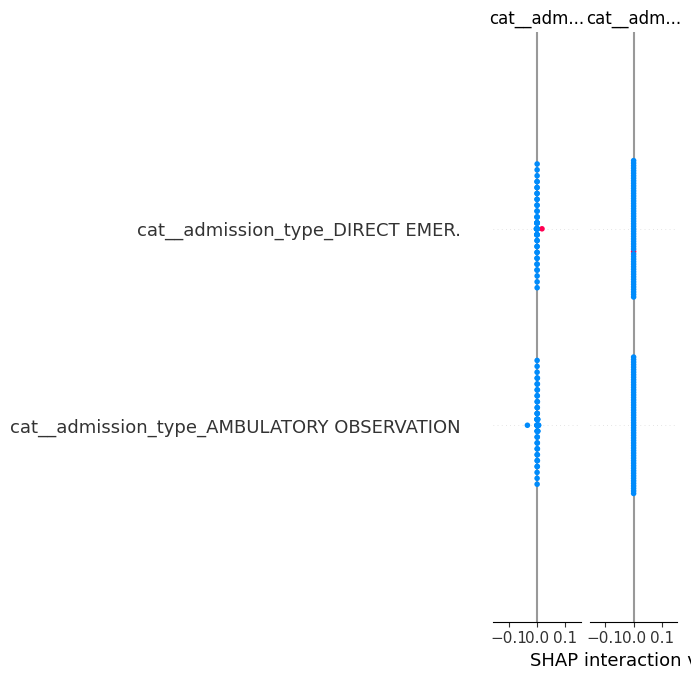

{'auc': 0.6127450980392156,
 'total_leaves': np.int64(2305),
 'avg_leaves': np.float64(23.05),
 'shap_importance': [('cat__admission_type_DIRECT EMER.',
   np.float64(0.00186128924423173)),
  ('cat__admission_type_AMBULATORY OBSERVATION',
   np.float64(0.0018612888765166327))]}

In [132]:
import shap
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score

def test(n, X_train, y_train, X_valid, y_valid, preprocessor):
    model = RandomForestClassifier(n_estimators=n, random_state=44)
    my_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    my_pipeline.fit(X_train, y_train)
    
    preds = my_pipeline.predict_proba(X_valid)[:, 1]
    auc = roc_auc_score(y_valid, preds)
    
    trained_model = my_pipeline.named_steps['model']
    total_leaves = sum([tree.get_n_leaves() for tree in trained_model.estimators_])
    avg_leaves = total_leaves / n
    
    X_valid_transformed = my_pipeline.named_steps['preprocessor'].transform(X_valid)
    if hasattr(X_valid_transformed, "toarray"):
        X_valid_transformed = X_valid_transformed.toarray()
    
    explainer = shap.Explainer(trained_model, X_valid_transformed)
    shap_values = explainer(X_valid_transformed)
    
    feature_names = my_pipeline.named_steps['preprocessor'].get_feature_names_out()
    shap_importance = np.abs(shap_values.values[1]).mean(axis=0)
    
    importance_df = sorted(
        zip(feature_names, shap_importance),
        key=lambda x: x[1],
        reverse=True
    )

    shap.summary_plot(shap_values, features=X_valid_transformed, feature_names=feature_names, show=True)
    
    
    return {
        'auc': auc,
        'total_leaves': total_leaves,
        'avg_leaves': avg_leaves,
        'shap_importance': importance_df
    }


test(n=100, X_train=X_train, 
    y_train=y_train, 
    X_valid=X_valid, 
    y_valid=y_valid, 
    preprocessor=preprocessor)